In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-25 16:56:10.143568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:10.143789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:10.160235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:10.160474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:10.160644: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

#max_epochs = 200
#batch_size_setval = 10000
#learning_rate_setval = 1e-3
#patience_setval = 10

#back = 0.1 #fraction of a background process that we would like to subtract
#background_param = (0, 1.2)  # background
#N = 10**5





##-- more thorough set with more events, higher background, wider background width 

max_epochs = 200
batch_size_setval = 1000
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 3*10**5





In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 1.51 s, sys: 10.2 ms, total: 1.52 s
Wall time: 1.52 s


In [9]:
theta0_G

array([ 0.38788954, -0.03837289,  0.79689551, ..., -0.23965966,
       -1.00654183, -0.20913027])

In [10]:
theta0_S

array([-10.        ,  -0.21280186,   1.99262169, ...,  -0.19139617,
        -0.84836302,  -0.27182807])

In [11]:
theta0

array([[  0.38788954, -10.        ],
       [ -0.03837289,  -0.21280186],
       [  0.79689551,   1.99262169],
       ...,
       [ -0.23965966,  -0.19139617],
       [ -1.00654183,  -0.84836302],
       [ -0.20913027,  -0.27182807]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(300000,)

In [14]:
theta0.shape

(300000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(300000,)

/tmp/ipykernel_2464224/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


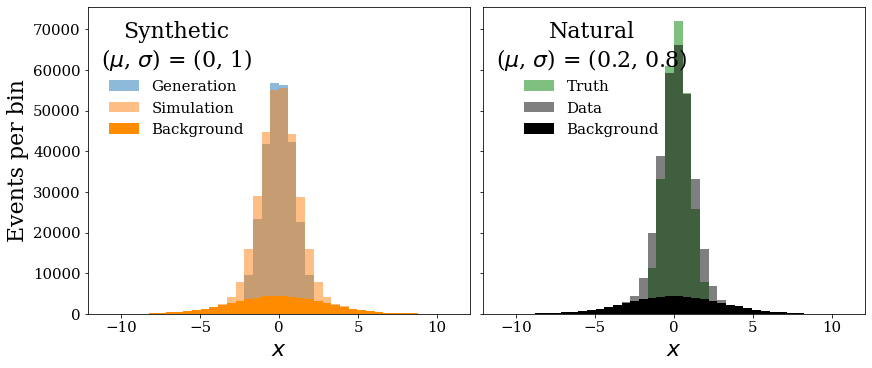

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-25 16:56:12.480885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:12.481091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:12.481263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:12.481423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:56:12.481583: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([-10.        ,  -0.21280186,   1.99262169, ...,   0.73312321,
         0.101989  ,   0.11998292])

In [21]:
xvals_1.shape

(600000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(600000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 22 ms, sys: 6.41 ms, total: 28.4 ms
Wall time: 28 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])


training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=max_epochs,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/200


2023-01-25 16:57:33.362724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-25 16:57:33.365534: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5616672adc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-25 16:57:33.365565: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-25 16:57:33.365573: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-25 16:57:33.371815: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-25 16:57:33.475500: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

540/540 [==============================] - 30s 52ms/step - loss: 0.5646 - accuracy: 0.4634 - val_loss: 0.5623 - val_accuracy: 0.4637
Epoch 2/200
540/540 [==============================] - 1s 3ms/step - loss: 0.5609 - accuracy: 0.4631 - val_loss: 0.5609 - val_accuracy: 0.4575
Epoch 3/200
540/540 [==============================] - 2s 3ms/step - loss: 0.5594 - accuracy: 0.4586 - val_loss: 0.5603 - val_accuracy: 0.4575
Epoch 4/200
540/540 [==============================] - 2s 3ms/step - loss: 0.5585 - accuracy: 0.4586 - val_loss: 0.5597 - val_accuracy: 0.4575
Epoch 5/200
540/540 [==============================] - 2s 3ms/step - loss: 0.5580 - accuracy: 0.4586 - val_loss: 0.5595 - val_accuracy: 0.4575
Epoch 6/200
540/540 [==============================] - 2s 3ms/step - loss: 0.5576 - accuracy: 0.4586 - val_loss: 0.5594 - val_accuracy: 0.4575
Epoch 7/200
540/540 [==============================] - 2s 3ms/step - loss: 0.5573 - accuracy: 0.4586 - val_loss: 0.5595 - val_accuracy: 0.4575
Epoch 8/2

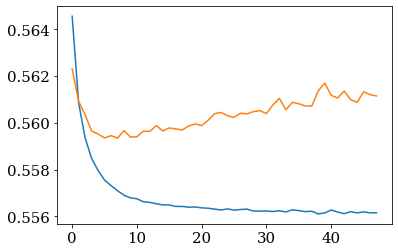

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

33/33 [==============================] - 0s 602us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_2464224/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


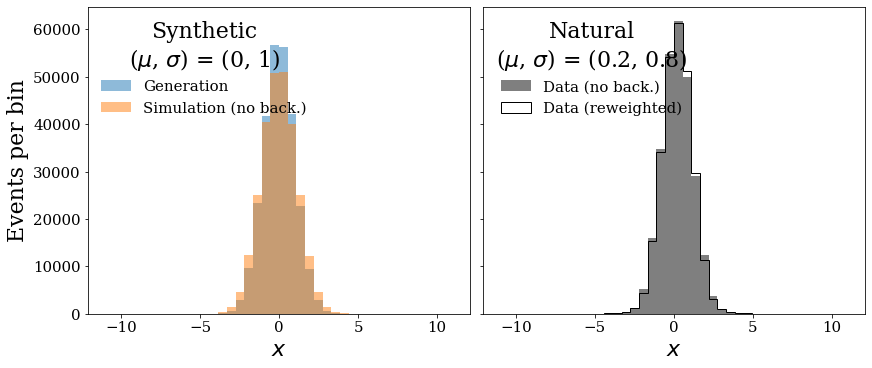

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

33/33 [==============================] - 0s 700us/step


In [32]:
model_output_bgsub

array([[0.4734437 ],
       [0.47674406],
       [0.48438722],
       ...,
       [0.20808275],
       [0.01568525],
       [0.04278734]], dtype=float32)

In [33]:
model_output_bgsub.shape

(329980, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([0.4734437 , 0.47674406, 0.48438722, ..., 0.20808275, 0.01568525,
       0.04278734], dtype=float32)

In [36]:
squeezed_model_output.shape

(329980,)

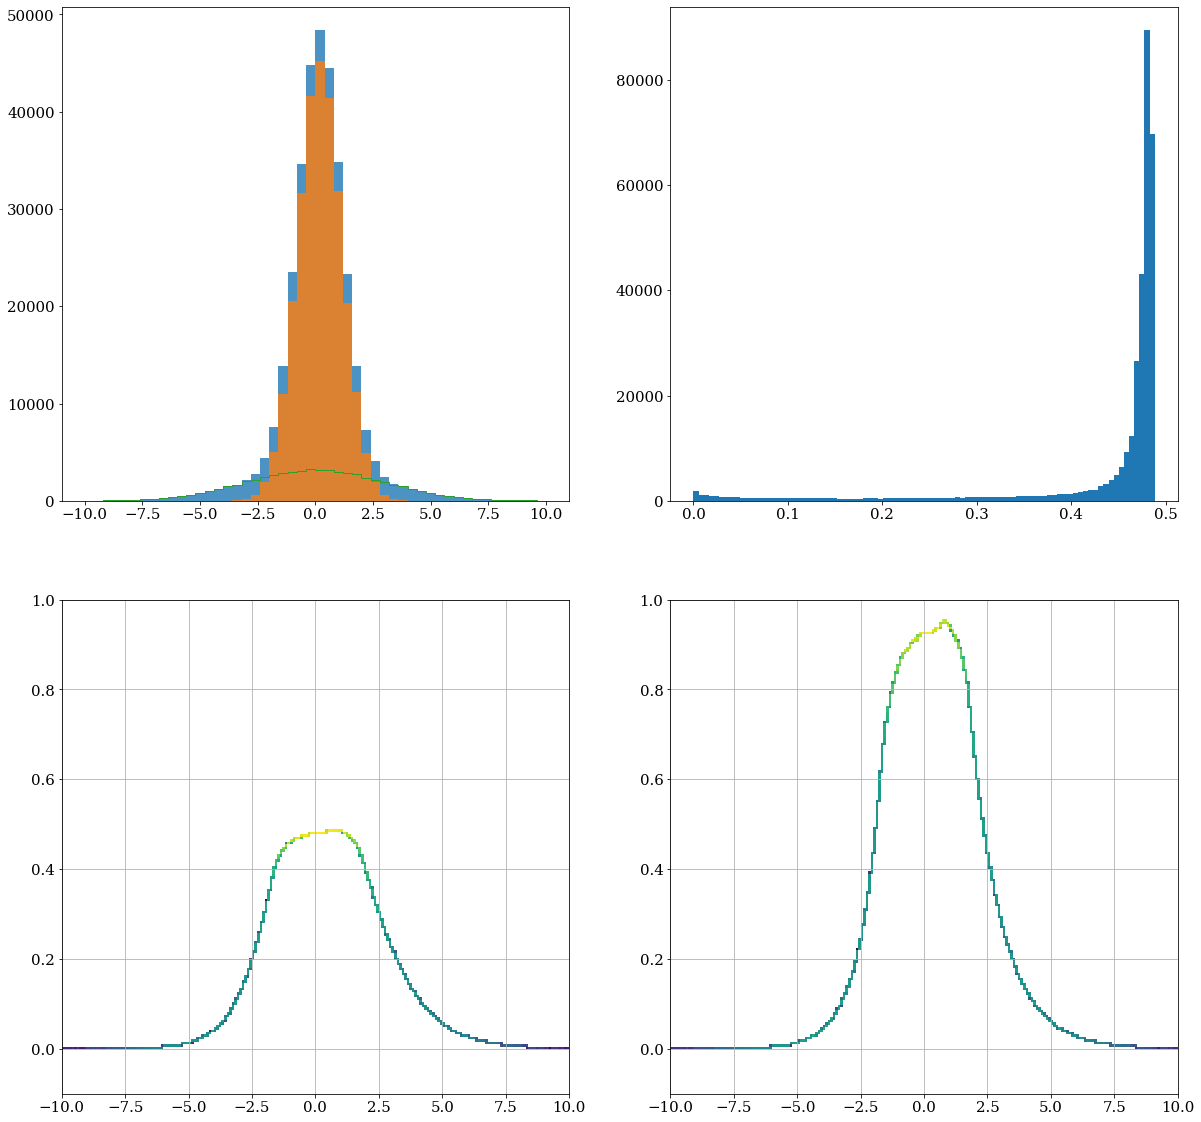

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

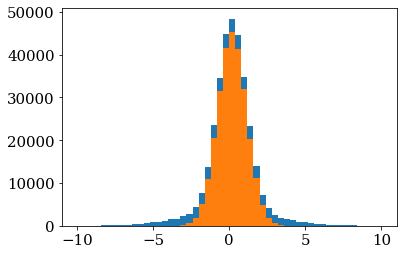

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([1.9000e+01, 2.4000e+01, 3.6000e+01, 5.5000e+01, 7.3000e+01,
        1.0100e+02, 1.4700e+02, 2.0800e+02, 2.9200e+02, 3.9500e+02,
        5.2100e+02, 6.0300e+02, 7.9800e+02, 9.8000e+02, 1.1980e+03,
        1.4880e+03, 1.6480e+03, 2.1860e+03, 2.7690e+03, 4.3550e+03,
        7.6180e+03, 1.3813e+04, 2.3477e+04, 3.4640e+04, 4.4847e+04,
        4.8387e+04, 4.4521e+04, 3.4838e+04, 2.3279e+04, 1.3864e+04,
        7.2670e+03, 4.1190e+03, 2.4750e+03, 1.7630e+03, 1.5220e+03,
        1.2490e+03, 9.7900e+02, 8.3900e+02, 6.4300e+02, 4.9200e+02,
        4.1300e+02, 2.7700e+02, 2.3400e+02, 1.4400e+02, 1.2100e+02,
        7.8000e+01, 4.9000e+01, 3.6000e+01, 2.9000e+01, 1.9000e+01]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6

In [40]:
hist_data_all[0]

array([1.9000e+01, 2.4000e+01, 3.6000e+01, 5.5000e+01, 7.3000e+01,
       1.0100e+02, 1.4700e+02, 2.0800e+02, 2.9200e+02, 3.9500e+02,
       5.2100e+02, 6.0300e+02, 7.9800e+02, 9.8000e+02, 1.1980e+03,
       1.4880e+03, 1.6480e+03, 2.1860e+03, 2.7690e+03, 4.3550e+03,
       7.6180e+03, 1.3813e+04, 2.3477e+04, 3.4640e+04, 4.4847e+04,
       4.8387e+04, 4.4521e+04, 3.4838e+04, 2.3279e+04, 1.3864e+04,
       7.2670e+03, 4.1190e+03, 2.4750e+03, 1.7630e+03, 1.5220e+03,
       1.2490e+03, 9.7900e+02, 8.3900e+02, 6.4300e+02, 4.9200e+02,
       4.1300e+02, 2.7700e+02, 2.3400e+02, 1.4400e+02, 1.2100e+02,
       7.8000e+01, 4.9000e+01, 3.6000e+01, 2.9000e+01, 1.9000e+01])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [45]:
signal_frac

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.02040816e-03, 8.34724541e-04, 2.01612903e-03,
       2.66990291e-02, 7.59377859e-02, 2.14517876e-01, 4.32606200e-01,
       6.54896298e-01, 7.94034605e-01, 8.73578396e-01, 9.12095843e-01,
       9.26907039e-01, 9.33949201e-01, 9.29898250e-01, 9.14920489e-01,
       8.75553074e-01, 8.04457588e-01, 6.78822072e-01, 4.70016994e-01,
       2.29090909e-01, 9.52921157e-02, 3.15374507e-02, 4.00320256e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

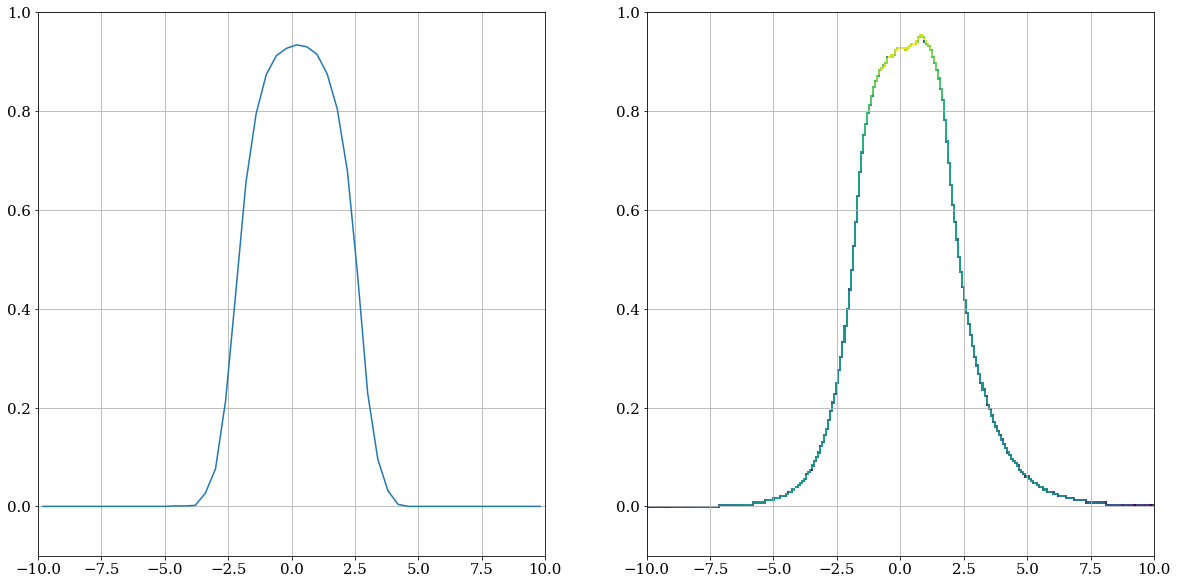

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time

for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    
    
    
    
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 







    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)


        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    
    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    
    

    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    
    weights_push = reweight(theta0_G)
    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    
    
    
    




ITERATION: 1




 Iteration 1,  STEP 1, events that pass reco



Epoch 1/200
450/450 [==============================] - 26s 57ms/step - loss: 0.6135 - accuracy: 0.5245 - val_loss: 0.6128 - val_accuracy: 0.5274
Epoch 2/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6125 - accuracy: 0.5286 - val_loss: 0.6124 - val_accuracy: 0.5267
Epoch 3/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6123 - accuracy: 0.5283 - val_loss: 0.6122 - val_accuracy: 0.5265
Epoch 4/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6121 - accuracy: 0.5277 - val_loss: 0.6121 - val_accuracy: 0.5254
Epoch 5/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6120 - accuracy: 0.5278 - val_loss: 0.6121 - val_accuracy: 0.5248
Epoch 6/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6119 - accuracy: 0.5272 - val_loss: 0.6119 - val_accuracy: 0.5263
Epoch 7/200
450/450 [==============================] - 1s 3ms/step - los

450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5477 - val_loss: 0.6107 - val_accuracy: 0.5490
Epoch 58/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5479 - val_loss: 0.6108 - val_accuracy: 0.5462
Epoch 59/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6108 - accuracy: 0.5479 - val_loss: 0.6107 - val_accuracy: 0.5460
Epoch 60/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6108 - accuracy: 0.5478 - val_loss: 0.6107 - val_accuracy: 0.5464
Epoch 61/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5477 - val_loss: 0.6108 - val_accuracy: 0.5463
Epoch 62/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6108 - accuracy: 0.5477 - val_loss: 0.6108 - val_accuracy: 0.5494
Epoch 63/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6108 - accuracy: 0.5476 - val_loss: 0.6108 - val_accuracy: 0.5479
Epoch

Epoch 114/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5476 - val_loss: 0.6107 - val_accuracy: 0.5478
Epoch 115/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5480 - val_loss: 0.6107 - val_accuracy: 0.5476
Epoch 116/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5480 - val_loss: 0.6107 - val_accuracy: 0.5454
Epoch 117/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5474 - val_loss: 0.6107 - val_accuracy: 0.5480
Epoch 118/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5481 - val_loss: 0.6108 - val_accuracy: 0.5453
Epoch 119/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5476 - val_loss: 0.6107 - val_accuracy: 0.5480
Epoch 120/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6107 - accuracy: 0.5478 - val_loss: 0.6107 - val_ac

Epoch 45/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.4999 - val_loss: 0.6881 - val_accuracy: 0.5003
Epoch 46/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5002 - val_loss: 0.6880 - val_accuracy: 0.5000
Epoch 47/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5002 - val_loss: 0.6886 - val_accuracy: 0.4996
Epoch 48/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.4997 - val_loss: 0.6881 - val_accuracy: 0.5002
Epoch 49/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5004 - val_loss: 0.6881 - val_accuracy: 0.4998
Epoch 50/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5000 - val_loss: 0.6880 - val_accuracy: 0.5004
Epoch 51/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5001 - val_loss: 0.6881 - val_accuracy:

450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5003 - val_loss: 0.6883 - val_accuracy: 0.4981
Epoch 5/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5004 - val_loss: 0.6884 - val_accuracy: 0.4993
Epoch 6/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5008 - val_loss: 0.6884 - val_accuracy: 0.4983
Epoch 7/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5005 - val_loss: 0.6885 - val_accuracy: 0.4984
Epoch 8/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6883 - accuracy: 0.5001 - val_loss: 0.6884 - val_accuracy: 0.4983
Epoch 9/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6883 - accuracy: 0.5003 - val_loss: 0.6884 - val_accuracy: 0.4994
Epoch 10/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5004 - val_loss: 0.6883 - val_accuracy: 0.4994
Epoch 11/2

450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.4998 - val_loss: 0.6884 - val_accuracy: 0.4992
Epoch 62/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5006 - val_loss: 0.6883 - val_accuracy: 0.4982
Epoch 63/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5005 - val_loss: 0.6884 - val_accuracy: 0.4993
Epoch 64/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5003 - val_loss: 0.6884 - val_accuracy: 0.4985
Epoch 65/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5003 - val_loss: 0.6884 - val_accuracy: 0.4993
Epoch 66/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5004 - val_loss: 0.6884 - val_accuracy: 0.4992
Epoch 67/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6883 - accuracy: 0.5002 - val_loss: 0.6886 - val_accuracy: 0.4982
Epoch

405/405 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.4997 - val_loss: 0.6914 - val_accuracy: 0.5004
Epoch 39/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.4999 - val_loss: 0.6913 - val_accuracy: 0.5001
Epoch 40/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.5002 - val_loss: 0.6913 - val_accuracy: 0.5004
Epoch 41/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.5003 - val_loss: 0.6913 - val_accuracy: 0.4993
Epoch 42/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.4995 - val_loss: 0.6915 - val_accuracy: 0.4995
Epoch 43/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6912 - accuracy: 0.5001 - val_loss: 0.6912 - val_accuracy: 0.5004
Epoch 44/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6912 - accuracy: 0.5004 - val_loss: 0.6913 - val_accuracy: 0.5005
Epoch

450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5493 - val_loss: 0.6228 - val_accuracy: 0.5452
Epoch 23/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5492 - val_loss: 0.6228 - val_accuracy: 0.5465
Epoch 24/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5496 - val_loss: 0.6228 - val_accuracy: 0.5446
Epoch 25/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5492 - val_loss: 0.6228 - val_accuracy: 0.5465
Epoch 26/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5495 - val_loss: 0.6228 - val_accuracy: 0.5447
Epoch 27/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5494 - val_loss: 0.6228 - val_accuracy: 0.5446
Epoch 28/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5495 - val_loss: 0.6228 - val_accuracy: 0.5462
Epoch

Epoch 79/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5495 - val_loss: 0.6228 - val_accuracy: 0.5475
Epoch 80/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5497 - val_loss: 0.6228 - val_accuracy: 0.5480
Epoch 81/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5497 - val_loss: 0.6228 - val_accuracy: 0.5447
Epoch 82/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5497 - val_loss: 0.6228 - val_accuracy: 0.5487
Epoch 83/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5498 - val_loss: 0.6228 - val_accuracy: 0.5469
Epoch 84/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5501 - val_loss: 0.6228 - val_accuracy: 0.5468
Epoch 85/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.5499 - val_loss: 0.6228 - val_accuracy:

Epoch 4/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.5003 - val_loss: 0.6787 - val_accuracy: 0.4996
Epoch 5/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.4998 - val_loss: 0.6787 - val_accuracy: 0.4991
Epoch 6/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.5000 - val_loss: 0.6787 - val_accuracy: 0.4989
Epoch 7/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.5003 - val_loss: 0.6787 - val_accuracy: 0.4996
Epoch 8/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.4999 - val_loss: 0.6786 - val_accuracy: 0.4995
Epoch 9/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.5001 - val_loss: 0.6786 - val_accuracy: 0.4992
Epoch 10/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6794 - accuracy: 0.5005 - val_loss: 0.6787 - val_accuracy: 0.499

Epoch 61/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6793 - accuracy: 0.5005 - val_loss: 0.6786 - val_accuracy: 0.4989
Epoch 62/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6793 - accuracy: 0.4999 - val_loss: 0.6785 - val_accuracy: 0.4992
Epoch 63/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6793 - accuracy: 0.5004 - val_loss: 0.6785 - val_accuracy: 0.4991
Epoch 64/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6793 - accuracy: 0.5000 - val_loss: 0.6786 - val_accuracy: 0.4992
Epoch 65/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6793 - accuracy: 0.4999 - val_loss: 0.6786 - val_accuracy: 0.4991
Epoch 66/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6794 - accuracy: 0.5003 - val_loss: 0.6786 - val_accuracy: 0.4988
Epoch 67/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6793 - accuracy: 0.5005 - val_loss: 0.6786 - val_accuracy:

450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.4997 - val_loss: 0.6797 - val_accuracy: 0.5005
Epoch 27/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.5001 - val_loss: 0.6797 - val_accuracy: 0.5005
Epoch 28/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6791 - accuracy: 0.4995 - val_loss: 0.6796 - val_accuracy: 0.5004
Epoch 29/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.5001 - val_loss: 0.6797 - val_accuracy: 0.5004
Epoch 30/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.4999 - val_loss: 0.6797 - val_accuracy: 0.5003
Epoch 31/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.4998 - val_loss: 0.6796 - val_accuracy: 0.5005
Epoch 32/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.4994 - val_loss: 0.6797 - val_accuracy: 0.5006
Epoch

405/405 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5002 - val_loss: 0.6878 - val_accuracy: 0.4979
Epoch 35/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5011 - val_loss: 0.6877 - val_accuracy: 0.4981
Epoch 36/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5006 - val_loss: 0.6877 - val_accuracy: 0.4979
Epoch 37/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5007 - val_loss: 0.6879 - val_accuracy: 0.4980
Epoch 38/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5008 - val_loss: 0.6879 - val_accuracy: 0.4980
Epoch 39/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5000 - val_loss: 0.6878 - val_accuracy: 0.4982
Epoch 40/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5005 - val_loss: 0.6879 - val_accuracy: 0.4981
Epoch

451/451 [==============================] - 1s 3ms/step - loss: 0.6238 - accuracy: 0.5373 - val_loss: 0.6236 - val_accuracy: 0.5341
Epoch 47/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6238 - accuracy: 0.5366 - val_loss: 0.6236 - val_accuracy: 0.5354
Epoch 48/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6238 - accuracy: 0.5341 - val_loss: 0.6236 - val_accuracy: 0.5351
Epoch 49/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6238 - accuracy: 0.5358 - val_loss: 0.6236 - val_accuracy: 0.5392
Epoch 50/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6238 - accuracy: 0.5366 - val_loss: 0.6236 - val_accuracy: 0.5463
Epoch 51/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6238 - accuracy: 0.5399 - val_loss: 0.6236 - val_accuracy: 0.5413
Epoch 52/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6238 - accuracy: 0.5383 - val_loss: 0.6236 - val_accuracy: 0.5287
Epoch

406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4999 - val_loss: 0.6763 - val_accuracy: 0.5008
Epoch 21/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.5003 - val_loss: 0.6762 - val_accuracy: 0.5001
Epoch 22/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4997 - val_loss: 0.6761 - val_accuracy: 0.5002
Epoch 23/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4996 - val_loss: 0.6761 - val_accuracy: 0.5008
Epoch 24/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4998 - val_loss: 0.6764 - val_accuracy: 0.5002
Epoch 25/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4995 - val_loss: 0.6761 - val_accuracy: 0.5009
Epoch 26/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4992 - val_loss: 0.6761 - val_accuracy: 0.5008
Epoch

Epoch 77/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.5001 - val_loss: 0.6761 - val_accuracy: 0.5009
Epoch 78/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6767 - accuracy: 0.4994 - val_loss: 0.6761 - val_accuracy: 0.5001
Epoch 79/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6767 - accuracy: 0.5000 - val_loss: 0.6762 - val_accuracy: 0.5001
Epoch 80/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4999 - val_loss: 0.6761 - val_accuracy: 0.5003
Epoch 81/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4997 - val_loss: 0.6761 - val_accuracy: 0.5008
Epoch 82/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4997 - val_loss: 0.6761 - val_accuracy: 0.5002
Epoch 83/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.4997 - val_loss: 0.6762 - val_accuracy:




 Iteration 3,  STEP 2, events that do NOT pass reco



30/30 [==============================] - 0s 647us/step
Epoch 1/200
405/405 [==============================] - 23s 57ms/step - loss: 0.6823 - accuracy: 0.4997 - val_loss: 0.6829 - val_accuracy: 0.4995
Epoch 2/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6820 - accuracy: 0.4999 - val_loss: 0.6827 - val_accuracy: 0.4995
Epoch 3/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6819 - accuracy: 0.4997 - val_loss: 0.6826 - val_accuracy: 0.5005
Epoch 4/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6819 - accuracy: 0.4998 - val_loss: 0.6826 - val_accuracy: 0.4996
Epoch 5/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6819 - accuracy: 0.4999 - val_loss: 0.6826 - val_accuracy: 0.5005
Epoch 6/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6819 - accuracy: 0.4998 - val_loss: 0.6826 - val_accuracy: 0.5002
Epoch 7/200
405/405 [======

451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5443 - val_loss: 0.6204 - val_accuracy: 0.5203
Epoch 3/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5373 - val_loss: 0.6204 - val_accuracy: 0.5396
Epoch 4/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5402 - val_loss: 0.6204 - val_accuracy: 0.5387
Epoch 5/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5452 - val_loss: 0.6204 - val_accuracy: 0.5394
Epoch 6/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5423 - val_loss: 0.6204 - val_accuracy: 0.5478
Epoch 7/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5463 - val_loss: 0.6204 - val_accuracy: 0.5375
Epoch 8/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5391 - val_loss: 0.6205 - val_accuracy: 0.5513
Epoch 9/200

451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5386 - val_loss: 0.6204 - val_accuracy: 0.5463
Epoch 60/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5409 - val_loss: 0.6204 - val_accuracy: 0.5511
Epoch 61/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5437 - val_loss: 0.6204 - val_accuracy: 0.5414
Epoch 62/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5446 - val_loss: 0.6204 - val_accuracy: 0.5357
Epoch 63/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5421 - val_loss: 0.6204 - val_accuracy: 0.5261
Epoch 64/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5391 - val_loss: 0.6204 - val_accuracy: 0.5505
Epoch 65/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6202 - accuracy: 0.5417 - val_loss: 0.6204 - val_accuracy: 0.5486
Epoch

Epoch 4/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.4996 - val_loss: 0.6757 - val_accuracy: 0.5006
Epoch 5/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.4994 - val_loss: 0.6757 - val_accuracy: 0.5013
Epoch 6/200
406/406 [==============================] - 1s 2ms/step - loss: 0.6759 - accuracy: 0.4996 - val_loss: 0.6757 - val_accuracy: 0.5004
Epoch 7/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.4993 - val_loss: 0.6756 - val_accuracy: 0.5011
Epoch 8/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.4991 - val_loss: 0.6756 - val_accuracy: 0.5002
Epoch 9/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.5003 - val_loss: 0.6758 - val_accuracy: 0.5002
Epoch 10/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.5001 - val_loss: 0.6758 - val_accuracy: 0.500

Epoch 61/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4995 - val_loss: 0.6759 - val_accuracy: 0.5012
Epoch 62/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4997 - val_loss: 0.6756 - val_accuracy: 0.5012
Epoch 63/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4997 - val_loss: 0.6756 - val_accuracy: 0.5005
Epoch 64/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4999 - val_loss: 0.6756 - val_accuracy: 0.5011
Epoch 65/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6757 - accuracy: 0.5004 - val_loss: 0.6757 - val_accuracy: 0.5004
Epoch 66/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4996 - val_loss: 0.6756 - val_accuracy: 0.5009
Epoch 67/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4996 - val_loss: 0.6756 - val_accuracy:

Epoch 118/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4997 - val_loss: 0.6756 - val_accuracy: 0.5013
Epoch 119/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6757 - accuracy: 0.4998 - val_loss: 0.6758 - val_accuracy: 0.5012
Epoch 120/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4999 - val_loss: 0.6757 - val_accuracy: 0.5004
Epoch 121/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6757 - accuracy: 0.4998 - val_loss: 0.6756 - val_accuracy: 0.5014
Epoch 122/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4993 - val_loss: 0.6756 - val_accuracy: 0.5012
Epoch 123/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.5001 - val_loss: 0.6759 - val_accuracy: 0.5006
Epoch 124/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4998 - val_loss: 0.6756 - val_ac

450/450 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4999 - val_loss: 0.6755 - val_accuracy: 0.4989
Epoch 50/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4999 - val_loss: 0.6755 - val_accuracy: 0.4989
Epoch 51/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6758 - accuracy: 0.5002 - val_loss: 0.6755 - val_accuracy: 0.5008
Epoch 52/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4995 - val_loss: 0.6755 - val_accuracy: 0.4987
Epoch 53/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.5000 - val_loss: 0.6755 - val_accuracy: 0.4990
Epoch 54/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.4997 - val_loss: 0.6755 - val_accuracy: 0.5007
Epoch 54: early stopping



 Iteration 4,  STEP 2, events that do NOT pass reco



30/30 [==============================] - 0s 587us/step
Epoch 1/200

405/405 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.4995 - val_loss: 0.6825 - val_accuracy: 0.5004
Epoch 51/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.4998 - val_loss: 0.6823 - val_accuracy: 0.5008
Epoch 52/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.4998 - val_loss: 0.6824 - val_accuracy: 0.5011
Epoch 53/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.4996 - val_loss: 0.6824 - val_accuracy: 0.5007
Epoch 54/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.4995 - val_loss: 0.6824 - val_accuracy: 0.5008
Epoch 55/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.4997 - val_loss: 0.6823 - val_accuracy: 0.5009
Epoch 56/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.5000 - val_loss: 0.6824 - val_accuracy: 0.5008
Epoch

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

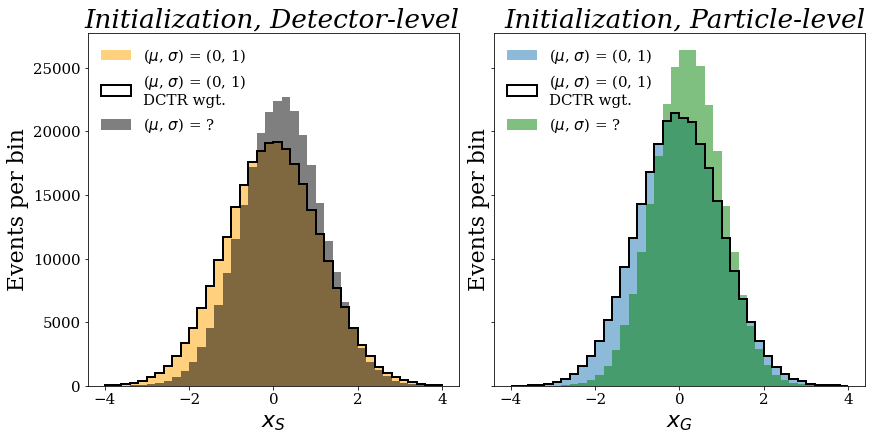

<Figure size 864x360 with 0 Axes>

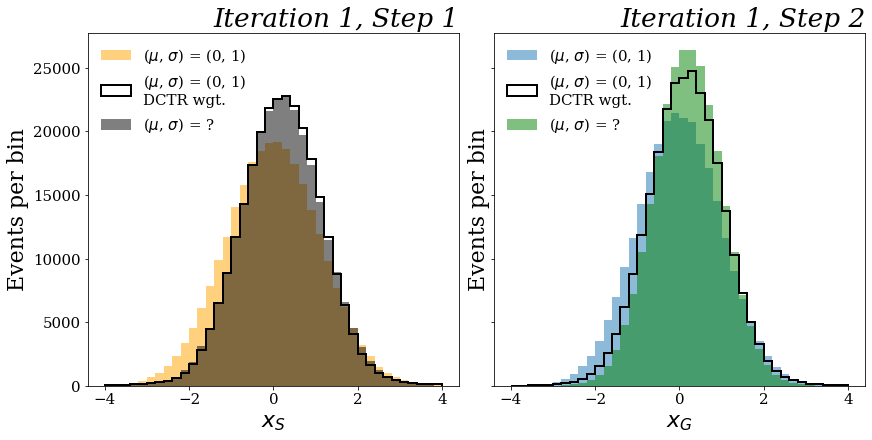

<Figure size 864x360 with 0 Axes>

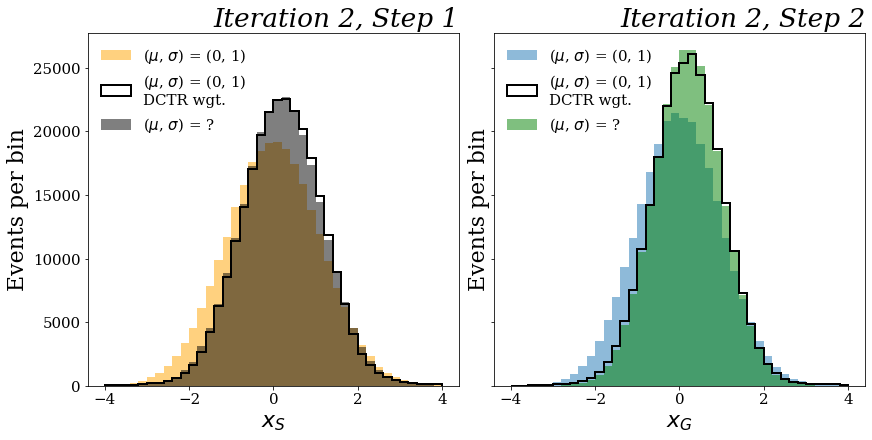

<Figure size 864x360 with 0 Axes>

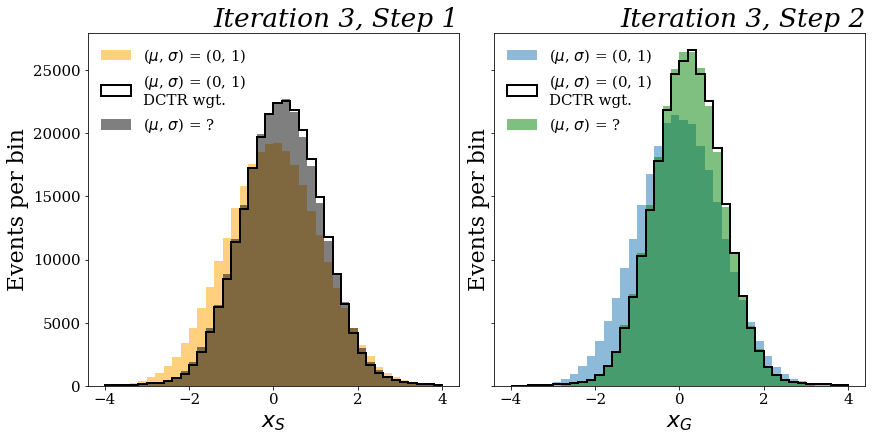

<Figure size 864x360 with 0 Axes>

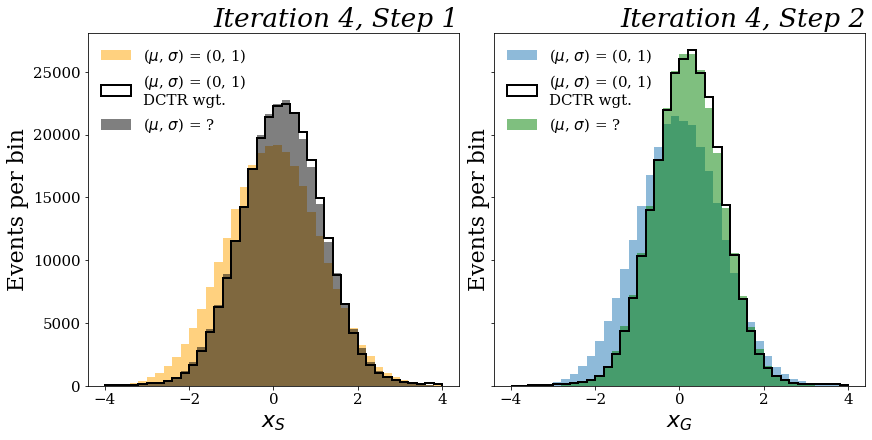

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.19080055, 1.10382354, 0.83101338, ..., 1.11412609,
         0.84913456, 1.08460844],
        [1.2036078 , 1.12274086, 1.21508598, ..., 1.0706687 ,
         0.79077023, 1.08196843]],

       [[1.26441777, 1.16264331, 0.9925673 , ..., 1.11011493,
         0.72728771, 1.11025512],
        [1.27513647, 1.16478229, 1.30047584, ..., 1.09391427,
         0.69227344, 1.10976422]],

       [[1.29131329, 1.18483019, 1.10107458, ..., 1.11261058,
         0.66654074, 1.12872171],
        [1.28928792, 1.16966712, 1.32140267, ..., 1.08607852,
         0.65897185, 1.10522926]],

       [[1.29114211, 1.19085002, 1.1752671 , ..., 1.102898  ,
         0.65993595, 1.12775612],
        [1.29982555, 1.1836971 , 1.34003794, ..., 1.08765841,
         0.65609044, 1.10809195]]])

In [53]:
weights.shape

(4, 2, 300000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([-6.77839217, -6.75129711,  5.54708847, ...,  3.1443283 ,
        6.72782953, -3.98102239])

In [57]:
x_data_and_MCback.shape

(719960,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(719960,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(719960,)

In [62]:
w_data

array([0.89913213, 0.91111064, 0.9394399 , ..., 0.2627582 , 0.0159352 ,
       0.04469993], dtype=float32)

In [63]:
w_data.shape

(329980,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([-0.52886516, -0.40934556,  0.61618994, ...,  3.1443283 ,
        6.72782953, -3.98102239])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(329980,)

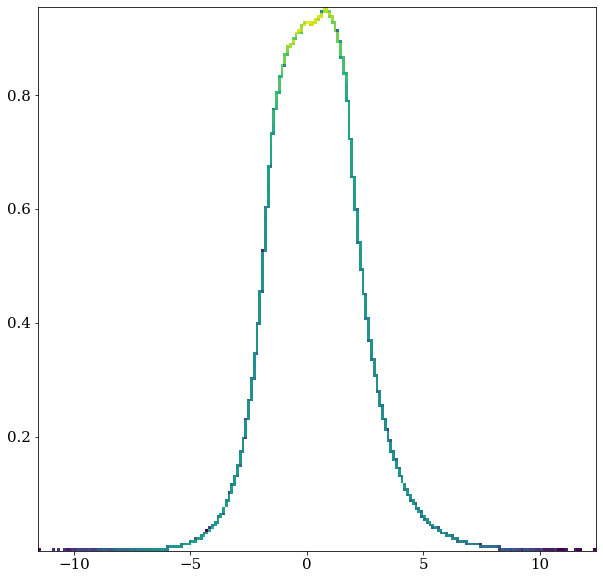

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

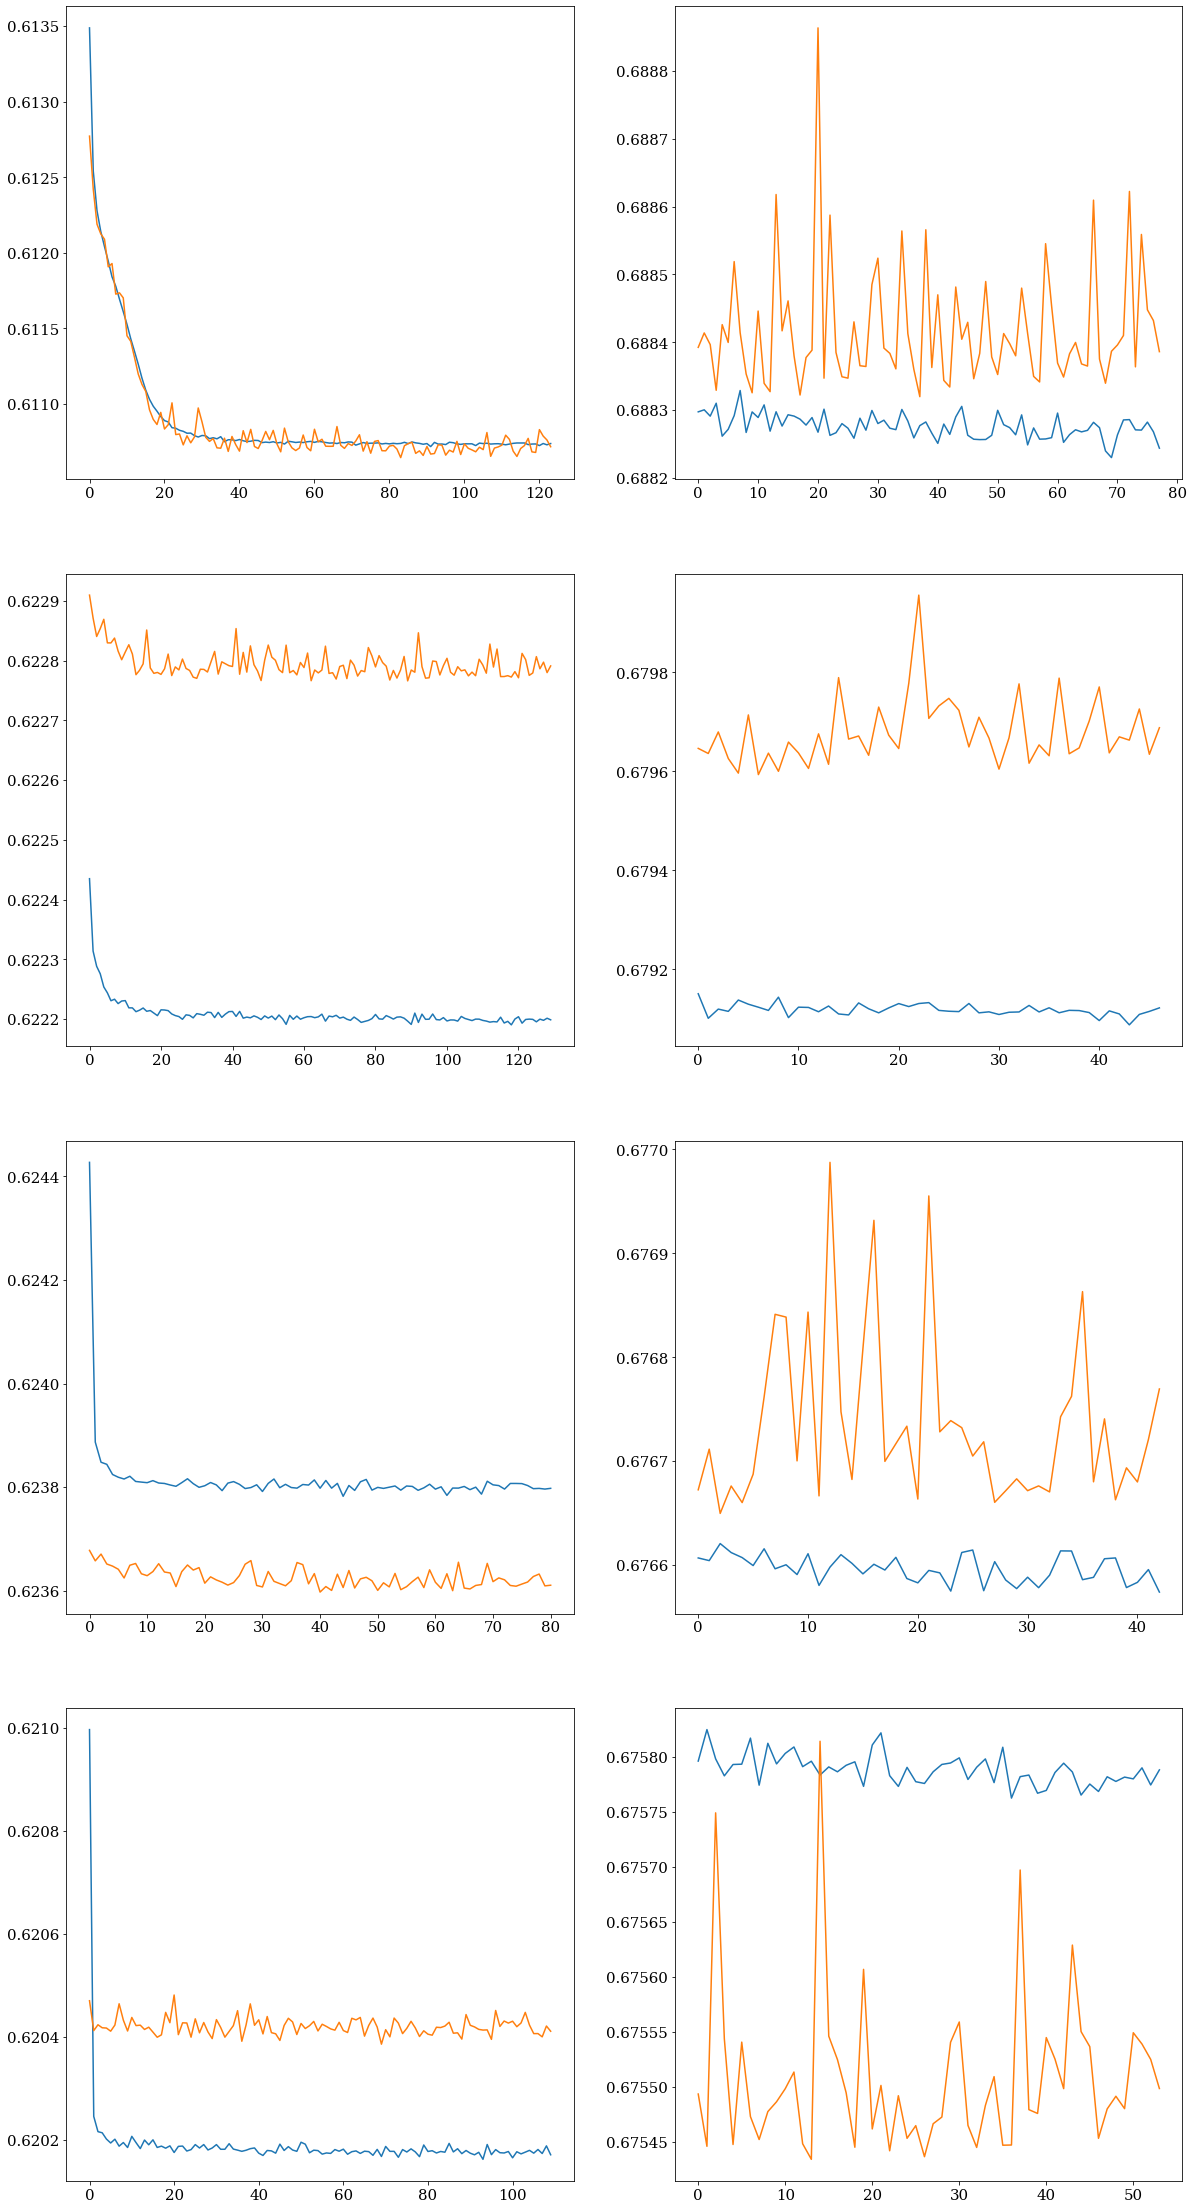

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()